### Import Packages<a href="#Import-Packages" class="anchor-link">¶</a>

In \[1\]:

    # Python Packages
    import tweepy
    import pandas as pd
    import numpy as np
    import csv
    import os
    import time

    # Sentiment Analysis Package
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

    # Pattern Matching
    import re

    # Visualization
    import matplotlib.pyplot as plt
    import seaborn as sns

    # NLTK
    import nltk
    from nltk import download
    nltk.download('wordnet')
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    from nltk.stem import WordNetLemmatizer

    # Model Packages
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression
    from sklearn.naive_bayes import BernoulliNB
    from sklearn import metrics
    from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix,accuracy_score, f1_score
    import joblib

    from wordcloud import WordCloud
    from collections import Counter
    # Stopwords
    download('stopwords')

    # Multiple outputs on notebook
    from IPython.core.interactiveshell import InteractiveShell
    InteractiveShell.ast_node_interactivity = "all"

    [nltk_data] Downloading package wordnet to
    [nltk_data]     /home/azureuser/nltk_data...
    [nltk_data]   Package wordnet is already up-to-date!
    [nltk_data] Downloading package stopwords to
    [nltk_data]     /home/azureuser/nltk_data...
    [nltk_data]   Package stopwords is already up-to-date!

### Extract Tweets About Movies<a href="#Extract-Tweets-About-Movies" class="anchor-link">¶</a>

In \[2\]:

    # Upload movies_list file
    df = pd.read_csv('movies_list.csv')
    df.head()

Out\[2\]:

|     | movie                          | top\_ten\_rank |
|-----|--------------------------------|----------------|
| 0   | 21                             | 1              |
| 1   | 21 Bridges                     | 1              |
| 2   | A Madea Homecoming             | 1              |
| 3   | A Nightmare on Elm Street 1984 | 0              |
| 4   | A Nightmare on Elm Street 2010 | 0              |

In \[3\]:

    # Movie names
    movies_list = df['movie']

In \[4\]:

    # Function to generate hashtag from movie names
    def generate_hashtag(movie_name):
        movie_name = movie_name.lower()
        movie_name = movie_name.strip().replace(" ", "")
        movie_name = ''.join(char for char in movie_name if char.isalnum())
        movie_hashtag = "#" + movie_name
        return movie_hashtag

#### Twitter authentication<a href="#Twitter-authentication" class="anchor-link">¶</a>

In \[6\]:

    # Twitter Config Parameters
    bearer_token = '###'

In \[7\]:

    # Twitter Authentication
    auth = tweepy.OAuth2BearerHandler(bearer_token)

    # Creating the API object while passing in auth information
    api = tweepy.API(auth, wait_on_rate_limit=True)

#### Query tweets<a href="#Query-tweets" class="anchor-link">¶</a>

In \[ \]:

    max_count = 10000
    created_date = []
    tweet_id = []
    movies = []
    texts = []

    # Connection time out error when running all files

    for movie in movies_list[81:]:  
        print("Processing Movie: ", movie)
        movie_hashtag = generate_hashtag(movie)

        
        for tweet in tweepy.Cursor(api.search_tweets, q=movie_hashtag, count=max_count, lang="en").items():        
            if 'RT @' not in tweet.text: #Ignore retweets
                tweet_id.append(tweet.id)
                created_date.append(tweet.created_at)
                movies.append(movie)
                texts.append(tweet.text)
                   

    tweets = pd.DataFrame(list(zip(created_date, tweet_id, movies, texts)), 
                     columns=['created_at', 'id', 'movie', 'text'])
    print(tweets.shape)

In \[ \]:

    # Add new tweets to old tweets file
    if os.path.exists("tweets.csv"):
        old_tweets = pd.read_csv("tweets.csv", encoding='unicode_escape')
        
        # Now merge all the data to this file
        final_df = pd.concat([old_tweets, tweets])

        # Remove duplicates if any
        final_df = final_df.drop_duplicates()
    else:
        final_df = tweets

    final_df.to_csv("tweets.csv", index=False)
    print(final_df.shape)

In \[8\]:

    # Use in case of system refresh
    final_df = pd.read_csv("tweets.csv", encoding='unicode_escape')
    print(final_df.shape)

    (46270, 4)

### Data Preprocessing - Clean text data<a href="#Data-Preprocessing---Clean-text-data" class="anchor-link">¶</a>

In \[9\]:

    # Data Preprocessing
    def processTweets(tweet):
        try:
            # convert text to lower-case
            tweet = tweet.lower()  

            # remove URLs, http links
            tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', tweet) 

            # remove @usernames
            tweet = re.sub('@[^\s]+', ' ', tweet) 

            # remove hashtags
            tweet = re.sub('#[^\s]+', ' ', tweet)  

            # remove all non-alphabet characters
            tweet = re.sub('[^a-zA-Z#]', ' ', tweet) 

            # word puntuations
            tweet = re.sub(r'[^\w\s]', '', (tweet)) 

            # tokenize
            tweet = word_tokenize(tweet)  

            # remove stopwords and word length < than 2
            cleaned_text = [word for word in tweet if (word not in set(stopwords.words('english')) and len(word) > 2)]
            cleaned_text = " ".join(cleaned_text)
        
        except:
            cleaned_text = tweet
        
        return cleaned_text

### Sentiment Analysis - Vader<a href="#Sentiment-Analysis---Vader" class="anchor-link">¶</a>

In \[10\]:

    # Clean Tweets
    final_df['cleaned_tweet'] = final_df['text'].apply(lambda x: processTweets(x))

    analyzer = SentimentIntensityAnalyzer()

    bins_cuts = [-1.0, -0.05, 0.05, 1.0]
    names = ['Negative', 'Neutral', 'Positive']

    # Process sentiment analysis on clean tweets 
    final_df['sentiment_score'] = final_df['cleaned_tweet'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
    final_df['sentiment'] = pd.cut(np.array(final_df['sentiment_score']), bins_cuts, labels=names)
    final_df.head()

Out\[10\]:

|     | created\_at               | id           | movie               | text                                                | cleaned\_tweet                                    | sentiment\_score | sentiment |
|-----|---------------------------|--------------|---------------------|-----------------------------------------------------|---------------------------------------------------|------------------|-----------|
| 0   | 2022-02-03 05:04:19+00:00 | 1.490000e+18 | The Tinder Swindler | To live isi Simon Leviev \#TheTinderSwindler ht...  | live isi simon leviev                             | 0.0000           | Neutral   |
| 1   | 2022-02-03 05:04:42+00:00 | 1.490000e+18 | Time                | ÃƒÂƒÃ‚ÂƒÃƒÂ‚Ã‚ÂƒÃƒÂƒÃ‚Â‚ÃƒÂ‚Ã‚ÂƒÃƒÂƒÃ‚ÂƒÃƒÂ‚Ã‚...   | picnic time brown seattle seahawks pilsner bee... | 0.4404           | Positive  |
| 2   | 2022-02-03 05:05:09+00:00 | 1.490000e+18 | The Tinder Swindler | Netflix has a grasp on my soul right now. Can ...   | netflix grasp soul right wait binge               | 0.0000           | Neutral   |
| 3   | 2022-02-03 05:05:09+00:00 | 1.490000e+18 | Time                | You waste \#energy &amp; lose \#time focusing on... | waste amp lose focusing people meant              | -0.6705          | Negative  |
| 4   | 2022-02-03 05:07:26+00:00 | 1.490000e+18 | After We Fell       | Tessa and Hardin ÃƒÂƒÃ‚ÂƒÃƒÂ‚Ã‚ÂƒÃƒÂƒÃ‚Â‚ÃƒÂ‚Ã...   | tessa hardin                                      | 0.0000           | Neutral   |

In \[11\]:

    # Create processed file
    final_df.to_csv('processed_data.csv', index=False)

### Prepare Data for Model Training<a href="#Prepare-Data-for-Model-Training" class="anchor-link">¶</a>

In \[12\]:

    # Read processed file
    final_df = pd.read_csv('processed_data.csv')
    final_df.head()

Out\[12\]:

|     | created\_at               | id           | movie               | text                                                | cleaned\_tweet                                    | sentiment\_score | sentiment |
|-----|---------------------------|--------------|---------------------|-----------------------------------------------------|---------------------------------------------------|------------------|-----------|
| 0   | 2022-02-03 05:04:19+00:00 | 1.490000e+18 | The Tinder Swindler | To live isi Simon Leviev \#TheTinderSwindler ht...  | live isi simon leviev                             | 0.0000           | Neutral   |
| 1   | 2022-02-03 05:04:42+00:00 | 1.490000e+18 | Time                | ÃƒÂƒÃ‚ÂƒÃƒÂ‚Ã‚ÂƒÃƒÂƒÃ‚Â‚ÃƒÂ‚Ã‚ÂƒÃƒÂƒÃ‚ÂƒÃƒÂ‚Ã‚...   | picnic time brown seattle seahawks pilsner bee... | 0.4404           | Positive  |
| 2   | 2022-02-03 05:05:09+00:00 | 1.490000e+18 | The Tinder Swindler | Netflix has a grasp on my soul right now. Can ...   | netflix grasp soul right wait binge               | 0.0000           | Neutral   |
| 3   | 2022-02-03 05:05:09+00:00 | 1.490000e+18 | Time                | You waste \#energy &amp; lose \#time focusing on... | waste amp lose focusing people meant              | -0.6705          | Negative  |
| 4   | 2022-02-03 05:07:26+00:00 | 1.490000e+18 | After We Fell       | Tessa and Hardin ÃƒÂƒÃ‚ÂƒÃƒÂ‚Ã‚ÂƒÃƒÂƒÃ‚Â‚ÃƒÂ‚Ã...   | tessa hardin                                      | 0.0000           | Neutral   |

In \[13\]:

    # Processed file info
    final_df.info()

    <class 'pandas.core.frame.DataFrame'>
    RangeIndex: 46270 entries, 0 to 46269
    Data columns (total 7 columns):
    created_at         46270 non-null object
    id                 46270 non-null float64
    movie              46270 non-null object
    text               46270 non-null object
    cleaned_tweet      44650 non-null object
    sentiment_score    46270 non-null float64
    sentiment          46270 non-null object
    dtypes: float64(2), object(5)
    memory usage: 2.5+ MB

In \[14\]:

    # Group data by mean sentiment score and number of tweets per movie
    data = final_df.groupby(['movie'])['sentiment_score'].agg(['mean', 'size']).reset_index()
    data.head()

Out\[14\]:

|     | movie              | mean     | size |
|-----|--------------------|----------|------|
| 0   | 21                 | 0.150159 | 22   |
| 1   | 21 Bridges         | 0.137863 | 19   |
| 2   | A Madea Homecoming | 0.104149 | 88   |
| 3   | After We Fell      | 0.213780 | 181  |
| 4   | Against The Ice    | 0.243400 | 63   |

In \[15\]:

    # Add rank class to each movie
    data = pd.merge(data, df)
    data.head()

Out\[15\]:

|     | movie              | mean     | size | top\_ten\_rank |
|-----|--------------------|----------|------|----------------|
| 0   | 21                 | 0.150159 | 22   | 1              |
| 1   | 21 Bridges         | 0.137863 | 19   | 1              |
| 2   | A Madea Homecoming | 0.104149 | 88   | 1              |
| 3   | After We Fell      | 0.213780 | 181  | 1              |
| 4   | Against The Ice    | 0.243400 | 63   | 1              |

### EDA and Data Visualization<a href="#EDA-and-Data-Visualization" class="anchor-link">¶</a>

#### Ungrouped Data<a href="#Ungrouped-Data" class="anchor-link">¶</a>

Bar chart - Number of tweets per type of sentiment

In \[16\]:

    ud_size = final_df.groupby(['sentiment']).size()
    ud_size.plot.bar()

Out\[16\]:

    <matplotlib.axes._subplots.AxesSubplot at 0x7f44973fde48>

<img src="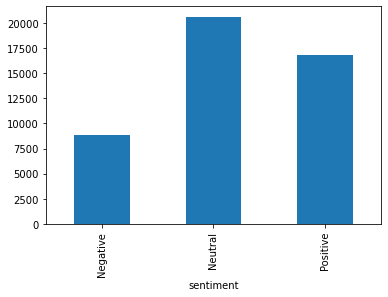%0A" class="jp-needs-light-background" />

Bar chart - 20 most common words

In \[19\]:

    from nltk.corpus import stopwords 
    stop_words = stopwords.words('english')

    freq_words = []
    for data_item in final_df['cleaned_tweet']:
        if data_item != "" and isinstance(data_item, str):
            for tt in range(len(data_item.split(" "))):
                freq_words.append(data_item.split(" ")[tt])
                
    most_common_words = Counter([word for word in freq_words if (word not in stop_words) and (len(word) >= 4)]).most_common(20)

    tmp = pd.DataFrame(most_common_words)

    # 20 most common words
    ax = tmp.plot.bar(x=0, y=1)
    plt.title("Most Common Words")
    plt.xticks(rotation=90)
    plt.xlabel("Words")
    plt.ylabel("Frequency")

Out\[19\]:

    Text(0.5, 1.0, 'Most Common Words')

Out\[19\]:

    (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19]),
     <a list of 20 Text major ticklabel objects>)

Out\[19\]:

    Text(0.5, 0, 'Words')

Out\[19\]:

    Text(0, 0.5, 'Frequency')

<img src="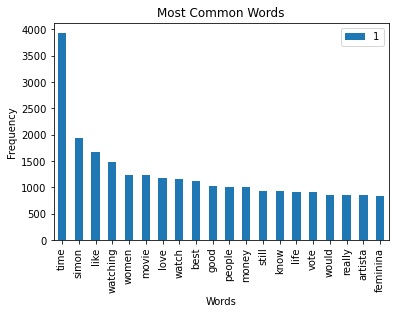%0A" class="jp-needs-light-background" />

WordCloud chart - Most popular words for trending and non-trending
movies

In \[21\]:

    final_df_rank = pd.merge(final_df, df)
    final_df_rank.head()

Out\[21\]:

|     | created\_at               | id           | movie               | text                                               | cleaned\_tweet                                    | sentiment\_score | sentiment | top\_ten\_rank |
|-----|---------------------------|--------------|---------------------|----------------------------------------------------|---------------------------------------------------|------------------|-----------|----------------|
| 0   | 2022-02-03 05:04:19+00:00 | 1.490000e+18 | The Tinder Swindler | To live isi Simon Leviev \#TheTinderSwindler ht... | live isi simon leviev                             | 0.0000           | Neutral   | 1              |
| 1   | 2022-02-03 05:05:09+00:00 | 1.490000e+18 | The Tinder Swindler | Netflix has a grasp on my soul right now. Can ...  | netflix grasp soul right wait binge               | 0.0000           | Neutral   | 1              |
| 2   | 2022-02-03 05:08:22+00:00 | 1.490000e+18 | The Tinder Swindler | Once they start asking for money, itÃƒÂƒÃ‚ÂƒÃƒ...  | start asking money time lmao                      | 0.5994           | Positive  | 1              |
| 3   | 2022-02-03 05:09:08+00:00 | 1.490000e+18 | The Tinder Swindler | The ending of the The Tinder Swindler actually...  | ending tinder swindler actually made fucking l... | 0.0038           | Neutral   | 1              |
| 4   | 2022-02-03 05:10:07+00:00 | 1.490000e+18 | The Tinder Swindler | I just watched \#TheTinderSwindler on Netflix, ... | watched netflix amp say actual fuck one           | -0.5423          | Negative  | 1              |

Trending Movies

In \[31\]:

    trend_freq_words = []
    for data_item in final_df_rank['cleaned_tweet'][final_df_rank['top_ten_rank']==1]:
        if data_item != "" and isinstance(data_item, str):
            for tt in range(len(data_item.split(" "))):
                trend_freq_words.append(data_item.split(" ")[tt])

    rmv_trend = [word for word in trend_freq_words if (len(word) <= 4)]
                
    trend_wordcloud = WordCloud(width = 1000, height = 1000, stopwords=rmv_trend, collocations=False,
                    background_color ='white',
                    min_font_size = 10).generate(" ".join(trend_freq_words))


    plt.figure(figsize=(5, 5), dpi=100)
    plt.imshow(trend_wordcloud)
    plt.axis("off")
    plt.title('Trending Movies')

Out\[31\]:

    <Figure size 500x500 with 0 Axes>

Out\[31\]:

    <matplotlib.image.AxesImage at 0x7f448df665f8>

Out\[31\]:

    (-0.5, 999.5, 999.5, -0.5)

Out\[31\]:

    Text(0.5, 1.0, 'Trending Movies')

<img src="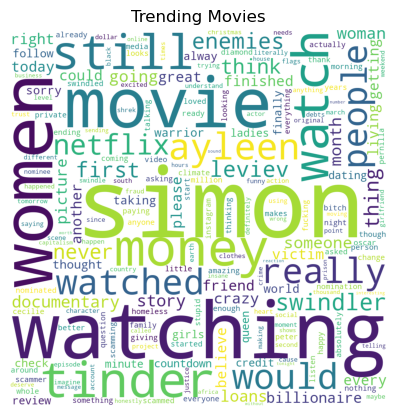%0A" class="jp-needs-light-background" />

Non-Trending Movies

In \[32\]:

    nontrend_freq_words = []
    for data_item in final_df_rank['cleaned_tweet'][final_df_rank['top_ten_rank']==0]:
        if data_item != "" and isinstance(data_item, str):
            for tt in range(len(data_item.split(" "))):
                nontrend_freq_words.append(data_item.split(" ")[tt])

    rmv_nontrend = [word for word in nontrend_freq_words if (len(word) <= 4)]
                
    nontrend_wordcloud = WordCloud(width = 1000, height = 1000, stopwords=rmv_nontrend, collocations=False,
                    background_color ='white',
                    min_font_size = 10).generate(" ".join(nontrend_freq_words))


    plt.figure(figsize=(5, 5), dpi=100)
    plt.imshow(nontrend_wordcloud)
    plt.axis("off")
    plt.title('Non-Trending Movies')

Out\[32\]:

    <Figure size 500x500 with 0 Axes>

Out\[32\]:

    <matplotlib.image.AxesImage at 0x7f448f2f2c88>

Out\[32\]:

    (-0.5, 999.5, 999.5, -0.5)

Out\[32\]:

    Text(0.5, 1.0, 'Non-Trending Movies')

<img src="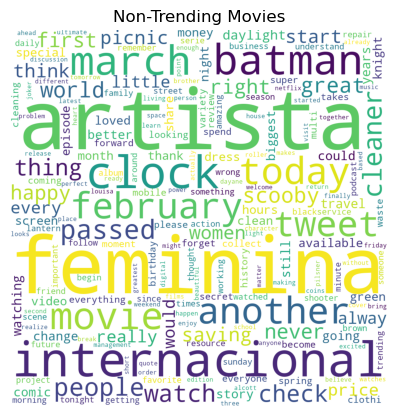%0A" class="jp-needs-light-background" />

Bar chart - Number of tweets by Sentiment type

In \[35\]:

    df_sentiment = final_df_rank.groupby(['movie','sentiment','top_ten_rank']).size().to_frame(name='count').reset_index()
    df_sentiment.head()

Out\[35\]:

|     | movie      | sentiment | top\_ten\_rank | count |
|-----|------------|-----------|----------------|-------|
| 0   | 21         | Negative  | 1              | 2     |
| 1   | 21         | Neutral   | 1              | 12    |
| 2   | 21         | Positive  | 1              | 8     |
| 3   | 21 Bridges | Negative  | 1              | 4     |
| 4   | 21 Bridges | Neutral   | 1              | 7     |

In \[37\]:

    sns.countplot(x="top_ten_rank", hue="sentiment", data=df_sentiment)

Out\[37\]:

    <matplotlib.axes._subplots.AxesSubplot at 0x7f448dc19ef0>

<img src="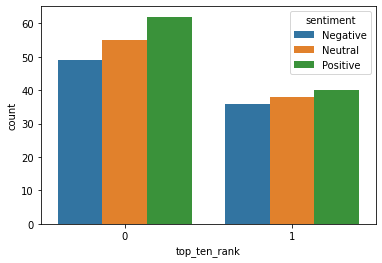%0A" class="jp-needs-light-background" />

#### Grouped Data<a href="#Grouped-Data" class="anchor-link">¶</a>

In \[38\]:

    data.info()

    <class 'pandas.core.frame.DataFrame'>
    Int64Index: 106 entries, 0 to 105
    Data columns (total 4 columns):
    movie           106 non-null object
    mean            106 non-null float64
    size            106 non-null int64
    top_ten_rank    106 non-null int64
    dtypes: float64(1), int64(2), object(1)
    memory usage: 4.1+ KB

In \[39\]:

    # Percentage of movies with select number of tweets
    print('% of movies with 100 tweets or more:', data['size'][data['size'] >= 100].count() / data['size'].count())
    print('% of movies with less than 100 tweets:', data['size'][data['size'] < 100].count() / data['size'].count())
    print('% of movies with less than 50 tweets:', data['size'][data['size'] < 50].count() / data['size'].count())

    % of movies with 100 tweets or more: 0.2830188679245283
    % of movies with less than 100 tweets: 0.7169811320754716
    % of movies with less than 50 tweets: 0.5943396226415094

### Model Training and Testing<a href="#Model-Training-and-Testing" class="anchor-link">¶</a>

In \[40\]:

    # Analysis Target Variable
    target = data['top_ten_rank']
    target.value_counts().sort_index().rename_axis('x').reset_index(name='f') 

Out\[40\]:

|     | x   | f   |
|-----|-----|-----|
| 0   | 0   | 63  |
| 1   | 1   | 43  |

In \[42\]:

    # Split Data for Training and Testing
    x=data[['mean', 'size']]
    y=target

    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.4, random_state=0)

In \[43\]:

    # Data evaluation model function
    def model_Evaluate(model):
        
        # predict test data
        y_pred = model.predict(x_test)
        
        # print accurancy of model
        acc=metrics.accuracy_score(y_test, y_pred)
        print("Accuracy of the model:",acc.round(2),"\n")

        # print evaluation metrics
        print(classification_report(y_test, y_pred))
        
        print(confusion_matrix(y_test, y_pred))

### Logistic Regression<a href="#Logistic-Regression" class="anchor-link">¶</a>

In \[44\]:

    # LR training and testing
    logistic = LogisticRegression()
    logistic.fit(x_train, y_train)
    model_Evaluate(logistic)

Out\[44\]:

    LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                       intercept_scaling=1, l1_ratio=None, max_iter=100,
                       multi_class='auto', n_jobs=None, penalty='l2',
                       random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                       warm_start=False)

    Accuracy of the model: 0.6 

                  precision    recall  f1-score   support

               0       0.61      0.96      0.75        26
               1       0.50      0.06      0.11        17

        accuracy                           0.60        43
       macro avg       0.55      0.51      0.43        43
    weighted avg       0.57      0.60      0.49        43

    [[25  1]
     [16  1]]

In \[45\]:

    # LR true and predicted responses
    log_y_pred = logistic.predict(x_test)
    log_y_test = y_test

    print('True', log_y_test.values[0:50])
    print('Pred', log_y_pred[0:50])

    True [1 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1
     0 1 0 1 0 1]
    Pred [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
     0 0 0 0 0 0]

In \[46\]:

    # LR accuracy score for training and testing
    # source: https://learning.oreilly.com/library/view/practical-data-science/9781801071970/Text/Chapter_12.xhtml#_idParaDest-265


    print('Training Accuracy Score:',logistic.score(x_train, y_train))
    print('Testing Accuracy Score:',logistic.score(x_test, y_test))

    Training Accuracy Score: 0.6031746031746031
    Testing Accuracy Score: 0.6046511627906976

In \[47\]:

    # LR confusion matrix
    # source: https://learning.oreilly.com/library/view/practical-data-science/9781801071970/Text/Chapter_12.xhtml#_idParaDest-269

    from sklearn.metrics import plot_confusion_matrix
    plot_confusion_matrix(logistic,
                          x_test,
                          y_test,
                          cmap=plt.cm.Blues,
                          display_labels=['not top 10', 'top 10'])

Out\[47\]:

    <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7f4490461470>

<img src="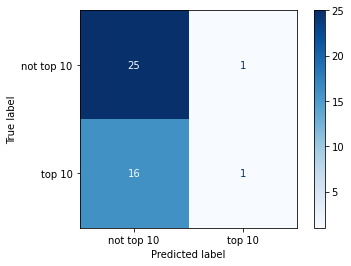%0A" class="jp-needs-light-background" />

In \[48\]:

    # LR ROC curve
    # source: https://learning.oreilly.com/library/view/practical-data-science/9781801071970/Text/Chapter_12.xhtml#_idParaDest-269

    from sklearn.metrics import plot_roc_curve
    roc = plot_roc_curve(logistic, x_test, y_test)
    plt.plot([0, 1], [0, 1], c='k', linestyle='dotted', label='random model')
    plt.plot([0, 0, 1],
             [0, 1, 1],
             c='k',
             linestyle='dashed',
             label='perfect model')
    plt.legend()

Out\[48\]:

    [<matplotlib.lines.Line2D at 0x7f4491e02ac8>]

Out\[48\]:

    [<matplotlib.lines.Line2D at 0x7f4491837cc0>]

Out\[48\]:

    <matplotlib.legend.Legend at 0x7f4491843940>

<img src="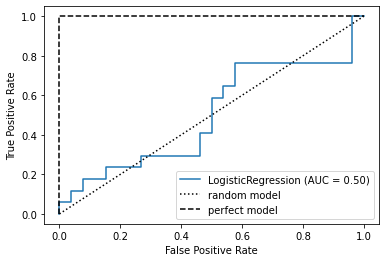%0A" class="jp-needs-light-background" />

### Bernoulli Naive Bayes<a href="#Bernoulli-Naive-Bayes" class="anchor-link">¶</a>

In \[49\]:

    # BNB training and testing
    nb = BernoulliNB()
    nb.fit(x_train, y_train)
    model_Evaluate(nb)

Out\[49\]:

    BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

    Accuracy of the model: 0.63 

                  precision    recall  f1-score   support

               0       0.62      0.96      0.76        26
               1       0.67      0.12      0.20        17

        accuracy                           0.63        43
       macro avg       0.65      0.54      0.48        43
    weighted avg       0.64      0.63      0.54        43

    [[25  1]
     [15  2]]

In \[50\]:

    # BNB true and predicted responses
    nb_y_pred = nb.predict(x_test)
    nb_y_test = y_test

    print('True', nb_y_test.values[0:50])
    print('Pred', nb_y_pred[0:50])

    True [1 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1
     0 1 0 1 0 1]
    Pred [0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
     0 0 0 0 0 0]

In \[51\]:

    # BNB confusion matrix
    # https://learning.oreilly.com/library/view/practical-data-science/9781801071970/Text/Chapter_12.xhtml#_idParaDest-269

    from sklearn.metrics import plot_confusion_matrix
    plot_confusion_matrix(nb,
                          x_test,
                          y_test,
                          cmap=plt.cm.Blues,
                          display_labels=['not top 10', 'top 10'])

Out\[51\]:

    <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7f4491837c18>

<img src="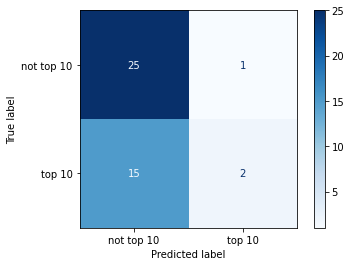%0A" class="jp-needs-light-background" />

In \[52\]:

    # BNB accuracy score for training and testing
    # https://learning.oreilly.com/library/view/practical-data-science/9781801071970/Text/Chapter_12.xhtml#_idParaDest-265

    print('Training Accuracy Score:',nb.score(x_train, y_train))
    print('Testing Accuracy Score:',nb.score(x_test, y_test))

    Training Accuracy Score: 0.6031746031746031
    Testing Accuracy Score: 0.627906976744186

In \[53\]:

    # BNB ROC curve
    # https://learning.oreilly.com/library/view/practical-data-science/9781801071970/Text/Chapter_12.xhtml#_idParaDest-269

    from sklearn.metrics import plot_roc_curve
    roc = plot_roc_curve(nb, x_test, y_test)
    plt.plot([0, 1], [0, 1], c='k', linestyle='dotted', label='random model')
    plt.plot([0, 0, 1],
             [0, 1, 1],
             c='k',
             linestyle='dashed',
             label='perfect model')
    plt.legend()

Out\[53\]:

    [<matplotlib.lines.Line2D at 0x7f4491de7080>]

Out\[53\]:

    [<matplotlib.lines.Line2D at 0x7f4491e02ef0>]

Out\[53\]:

    <matplotlib.legend.Legend at 0x7f448f308550>

<img src="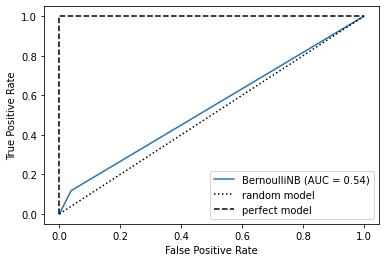%0A" class="jp-needs-light-background" />

#### F1-score Evaluation<a href="#F1-score-Evaluation" class="anchor-link">¶</a>

In \[54\]:

    print("Evaluation Report \n")

    # Logistic Regression
    reg_log=logistic.predict(x_test)                              

    # f1_score
    log_f1_score = f1_score(y_test, reg_log, average='weighted') 
    print("F1 score accuracy of Logistic Regression = " , log_f1_score)

    # Naive Bayes
    nb_log=nb.predict(x_test)

    # f1_score
    nb_f1_score = f1_score(y_test, nb_log, average='weighted') 
    print("F1 score accuracy of Bernoulli Naive Bayes = " , nb_f1_score)

    eva = {'F1-score':[log_f1_score, nb_f1_score]} 
      
    # Create dataframe
    performance = pd.DataFrame(eva, index =['Logistic Regression', 'Bernoulli Naive Bayes']) 
      
    # Print performance measures 
    performance

    Evaluation Report 

    F1 score accuracy of Logistic Regression =  0.4928478781124974
    F1 score accuracy of Bernoulli Naive Bayes =  0.5371388301620859

Out\[54\]:

|                       | F1-score |
|-----------------------|----------|
| Logistic Regression   | 0.492848 |
| Bernoulli Naive Bayes | 0.537139 |

#### Save Models<a href="#Save-Models" class="anchor-link">¶</a>

In \[ \]:

    import os
    os.makedirs("models")
    joblib.dump(logistic, 'models/logistic.sav')
    joblib.dump(nb, 'models/naiveBayes.sav')